# Extract features of augmented soundscapes using Mosqito library

We should get the same values that they provide in the responses.csv in ARAUS dataset

In [11]:
# Add MOSQITO to the Python path
import sys
sys.path.append('..')

# Import numpy
import numpy as np
# Import plot function
import matplotlib.pyplot as plt
# Import mosqito functions
from mosqito.utils import load
from mosqito.sq_metrics import loudness_zwtv
from scipy.io import wavfile
from scipy.signal import resample

# Import MOSQITO color sheme [Optional]
from mosqito import COLORS

# To get inline plots (specific to Jupyter notebook)
#%matplotlib notebook

In [12]:
def load(file, wav_calib=None, mat_signal="", mat_fs="", ch=None):
    """Extract the signal and its time axis from .wav or .uff file,
    resample the signal to 48 kHz, and affects its sampling frequency
    and time signal values.

    Parameters
    ----------
    file : string
        string path to the signal file
    wav_calib : float, optional
        Wav file calibration factor [Pa/FS]. Level of the signal in Pa_peak
        corresponding to the full scale of the .wav file. If None, a
        calibration factor of 1 is considered. Default to None.
    mat_signal : string
        in case of a .mat file, name of the signal variable
    mat_fs : string
        in case of a .mat file, name of the sampling frequency variable

    Outputs
    -------
    signal : numpy.array
        time signal values
    fs : integer
        sampling frequency
    """

    # load the .wav file content
    if file[-3:] == "wav" or file[-3:] == "WAV":
        fs, signal = wavfile.read(file)

        # manage multichannel files
        if signal.ndim > 1:
            signal = signal[:, ch] # signal[:, 0] for first channel, signal[:, 1] for second ch
            print("[Info] Multichannel signal loaded. Keeping only second channel")

        # calibration factor for the signal to be in Pa
        if wav_calib is None:
            wav_calib = 1
            print("[Info] A calibration of 1 Pa/FS is considered")
        if isinstance(signal[0], np.int16):
            signal = wav_calib * signal / (2**15 - 1)
        elif isinstance(signal[0], np.int32):
            signal = wav_calib * signal / (2**31 - 1)
        elif isinstance(signal[0], np.float):
            signal = wav_calib * signal

    else:
        raise ValueError("""ERROR: only .wav .mat or .uff files are supported""")

    # resample to 48kHz to allow calculation
    if fs != 48000:
        signal = resample(signal, int(48000 * len(signal) / fs))
        fs = 48000
        print("[Info] Signal resampled to 48 kHz to allow calculation.")

    return signal, fs


#### Load signal

[Info] Multichannel signal loaded. Keeping only second channel
[Info] Signal resampled to 48 kHz to allow calculation.


Text(0, 0.5, 'Acoustic pressure [Pa]')

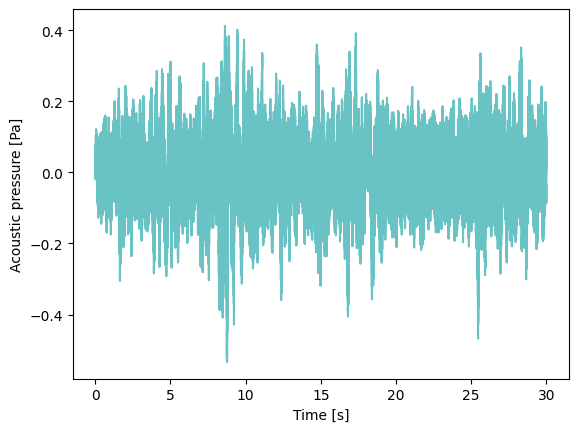

In [52]:
# Define path to the .wav file
# To be replaced by your own path
path = "../data/soundscapes_augmented/fold_1_participant_00001_stimulus_03.wav"
# load signal
#fs, sig = wavfile.read(path)
sig, fs = load(path, wav_calib=2 * 2 **0.5)
""" # keep only right channel
if(sig.shape[1]>1):
    sig=sig[:,1]
# if needed, resample to 48kHz
if fs != 48000:
    signal = resample(sig, int(48000 * len(sig) / fs))
    fs = 48000 """
# plot signal
t = np.linspace(0, (len(sig) - 1) / fs, len(sig))
plt.figure(1)
plt.plot(t, sig, color=COLORS[0])
plt.xlabel('Time [s]')
plt.ylabel('Acoustic pressure [Pa]')

#### Compute loudness

In [53]:
N, N_spec, bark_axis, time_axis = loudness_zwtv(sig, fs, field_type="free")

Text(0, 0.5, 'N_zwtv [sone]')

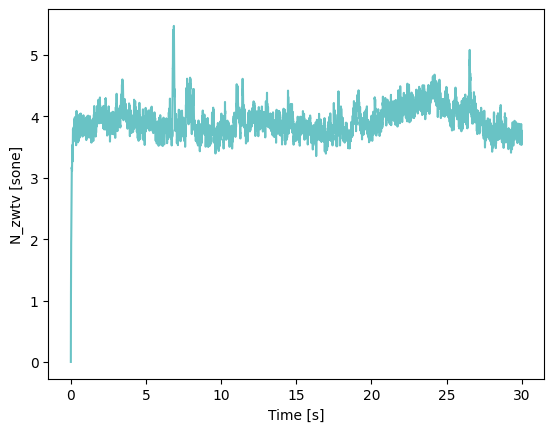

In [47]:
# The loudness of the audio signal is computed as a function of time :
plt.figure(2)
plt.plot(time_axis, N, color=COLORS[0])
plt.xlabel('Time [s]')
plt.ylabel('N_zwtv [sone]')

Text(0.5, 1.0, 't = 0.6 s')

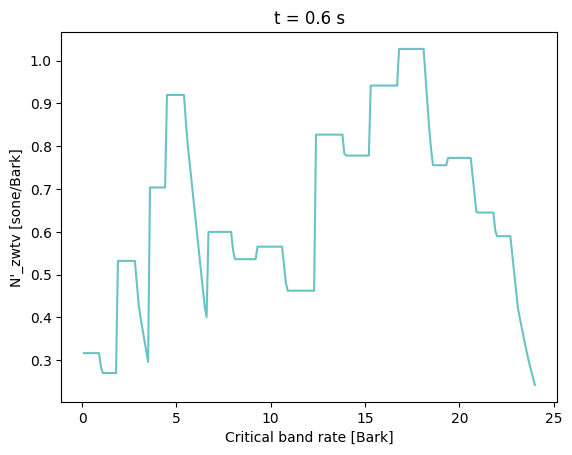

In [9]:
# The specific loudness over time and critical band rate is also computed. It can be plotted over critical band rate 
# for a specific time or over time for a specific critical band rate with the following commands:

i_time = 300
plt.figure(3)
plt.plot(bark_axis, N_spec[:, i_time], color=COLORS[0])
plt.xlabel('Critical band rate [Bark]')
plt.ylabel("N'_zwtv [sone/Bark]")
plt.title("t = {:.1f} s".format(time_axis[i_time]))

#### Calculate N_avg, N_max, percentiles...

In [54]:

N_avg=np.mean(N)

N_max=np.max(N)

N_95=np.percentile(N,95)

print(N_avg, N_max, N_95)

16.972762440998014


# Extract loudness for soundscape (non-augmented)

In [17]:
# Define path to the .wav file
# To be replaced by your own path
path = "../data/R0056_segment_binaural_44100_2.wav"
# load signal
#fs, sig = wavfile.read(path)
sigL, fs = load(path, wav_calib=(1/0.644716), ch=0) #L
sigR, fs = load(path, wav_calib=(1/0.644716), ch=1) #R

[Info] Multichannel signal loaded. Keeping only second channel
[Info] Signal resampled to 48 kHz to allow calculation.
[Info] Multichannel signal loaded. Keeping only second channel
[Info] Signal resampled to 48 kHz to allow calculation.


In [19]:
#L
N_l, N_spec_l, bark_axis_l, time_axis_l = loudness_zwtv(sigL, fs, field_type="free")
N_avg_l=np.mean(N_l)
N_max_l=np.max(N_l)
N_05_l=np.percentile(N_l,95)
print(N_avg_l, N_max_l, N_05_l)

#R
N_r, N_spec_r, bark_axis_r, time_axis_r = loudness_zwtv(sigR, fs, field_type="free")
N_avg_r=np.mean(N_r)
N_max_r=np.max(N_r)
N_05_r=np.percentile(N_r,95)
print(N_avg_r, N_max_r, N_05_r)



10.379606169016924 12.781628478703796 11.807209916762078
9.422715280108596 16.134197398391755 13.693931234847673


In [22]:
error_avg= 16.5-(N_avg_r+N_avg_l)
error_max= 25.3-(N_max_r+N_max_l)
error_05= 21.6-(N_05_r+N_05_l)

print(error_avg, error_max, error_05)

-3.3023214491255217 -3.615825877095549 -3.9011411516097496


In [20]:
#L+R
N_lr, N_spec_lr, bark_axis_lr, time_axis_lr = loudness_zwtv((sigR+sigL), fs, field_type="free")
N_avg_lr=np.mean(N_lr)
N_max_lr=np.max(N_lr)
N_05_lr=np.percentile(N_lr,95)
print(N_avg_lr, N_max_lr, N_05_l)

12.523217346134938 18.39546606385114 11.807209916762078
